In [ ]:
!pip install --quiet openai
# !pip install --quiet tensorflow
!pip install --quiet datasets
# !pip install --quiet transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.9 MB/s eta 0:00:00


In [ ]:
import warnings
import os
import pandas as pd
from google.colab import drive
import pickle
import numpy as np
from openai import *
import logging
import re
from tqdm import tqdm
import zipfile
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pickle

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
pd.options.mode.chained_assignment = None
import os #File location
for dirname, _, filenames in os.walk('/content/drive/MyDrive/AML/challenge3/dataset/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from wordcloud import WordCloud #Word visualization
import matplotlib.pyplot as plt #Plotting properties
import seaborn as sns #Plotting properties
from sklearn.feature_extraction.text import CountVectorizer #Data transformation
from sklearn.model_selection import train_test_split #Data testing
from sklearn.linear_model import LogisticRegression #Prediction Model
from sklearn.metrics import accuracy_score #Comparison between real and predicted
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder #Variable encoding and decoding for XGBoost
import re #Regular expressions
import nltk
from nltk import word_tokenize
nltk.download('stopwords')

/content/drive/MyDrive/AML/challenge3/dataset/sample_submission.csv
/content/drive/MyDrive/AML/challenge3/dataset/test.csv
/content/drive/MyDrive/AML/challenge3/dataset/train.csv


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
#Validation dataset
val=pd.read_csv("/content/drive/MyDrive/AML/challenge3/dataset/test.csv", header=None)
#Full dataset for Train-Test
train=pd.read_csv("/content/drive/MyDrive/AML/challenge3/dataset/train.csv", header=None)

In [ ]:
with open("/content/drive/MyDrive/AML/challenge3/train_data_embeddings.pkl", 'rb') as f:
    embeddings_train = pickle.load(f)
with open("/content/drive/MyDrive/AML/challenge3/val_data_embeddings.pkl", 'rb') as f:
    embeddings_val = pickle.load(f)

In [ ]:
with open("/content/drive/MyDrive/AML/challenge3/variations_df_gpt4o_val_unlabeled_2746_tweets.pkl", 'rb') as f:
    labeled_val = pickle.load(f)

In [ ]:
labeled_val.reset_index(drop=True, inplace=True)
labeled_val.index = labeled_val.index + 1

In [ ]:
# labeled_val['similarities']=embeddings_val['similarities']

In [ ]:
labeled_val

,ID,Tweet,Predicted_Sentiment,Extracted_Part,Original_Extracted_Text
1,0,happy mother s day hahaha,positive,happy mother's day,Happy Mother`s Day
2,1,sorry for the triple twitter post was having ...,neutral,sorry for the triple twitter post,"Sorry for the triple twitter post, was having ..."
3,2,thats much better than the flu syndrome,positive,much better,thats much better
4,3,aww i have a tummy ache,negative,tummy ache,tummy ache
5,4,hey chocolate chips is good i want a snack ...,positive,chocolate chips is good,good.
...,...,...,...,...,...
2744,2743,is also having a lonely night wishing she cou...,negative,having a lonely night,Is also having a lonely night.... Wishing she ...
2745,2744,o ok im jealous i wish i was in bed,negative,jealous,o ok..im jealous..i wish I was in bed
2746,2745,your in trouble now why don t you try with...,neutral,try with one of those companies,**** your in trouble now
2747,2746,happy mother day for all the strong hard worki...,positive,happy mother day,HAPPY MOTHER DAY FOR ALL THE STRONG HARD WORKI...


In [ ]:
train_data=train.copy()
val_data=val=val.copy()
train_data.columns=['ID','text','selected_text','sentiment']
val_data.columns=['ID','text','selected_text']
train_data=train_data.iloc[1: , :]
val_data=val_data.iloc[1: , :]

In [ ]:
train_data["lower"]=train_data.text.str.lower() #lowercase
train_data["lower"]=[str(data) for data in train_data.lower] #converting all to string
train_data["lower"]=train_data.lower.apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x)) #regex
val_data["lower"]=val_data.text.str.lower() #lowercase
val_data["lower"]=[str(data) for data in val_data.lower] #converting all to string
val_data["lower"]=val_data.lower.apply(lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x)) #regex

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove "http" and "https" prefixes
    text = re.sub(r'http://|https://', '', text, flags=re.MULTILINE)
    # Remove non-alphanumeric characters
    text = re.sub('[^A-Za-z0-9 ]+', ' ', text)
    # Tokenize text
    words = word_tokenize(text)
    # Remove stopwords and lemmatize words
    words = [lemmatizer.lemmatizer(word) for word in words if word not in stop_words]
    # Join words back to a single string
    return ' '.join(words)

In [ ]:
# Apply preprocessing to train_data and val_data
train_data["cleaned"] = train_data["text"].apply(preprocess_text)
val_data["cleaned"] = val_data["text"].apply(preprocess_text)

In [ ]:
train_data["sentiment"].value_counts()

sentiment
neutral     10018
positive     7711
negative     7003
Name: count, dtype: int64

In [ ]:
val_data

,ID,text,selected_text,lower,cleaned
1,102f98e5e2,Happy Mother`s Day hahaha,Happy Mother`s Day,happy mother s day hahaha,happy mother day hahaha
2,033b399113,"Sorry for the triple twitter post, was having ...","Sorry for the triple twitter post, was having ...",sorry for the triple twitter post was having ...,sorry triple twitter post trouble w stocktwits...
3,c125e29be2,thats much better than the flu syndrome!,thats much better,thats much better than the flu syndrome,thats much better flu syndrome
4,b91e2b0679,Aww I have a tummy ache,tummy ache,aww i have a tummy ache,aww tummy ache
5,1a46141274,hey chocolate chips is good. i want a snack ...,good.,hey chocolate chips is good i want a snack ...,hey chocolate chip good want snack snack
...,...,...,...,...,...
2744,0bfb1006b9,Is also having a lonely night.... Wishing she ...,Is also having a lonely night.... Wishing she ...,is also having a lonely night wishing she cou...,also lonely night wishing could go audun bad d...
2745,f1df499466,o ok..im jealous..i wish I was in bed,o ok..im jealous..i wish I was in bed,o ok im jealous i wish i was in bed,ok im jealous wish bed
2746,de4da367a4,**** your in trouble now why don`t you try w...,**** your in trouble now,your in trouble now why don t you try with...,trouble try one company buy house
2747,07a8ec4593,HAPPY MOTHER DAY FOR ALL THE STRONG HARD WORKI...,HAPPY MOTHER DAY FOR ALL THE STRONG HARD WORKI...,happy mother day for all the strong hard worki...,happy mother day strong hard working mother ma...


In [ ]:
val_data["sentiment"]=labeled_val['Predicted_Sentiment']

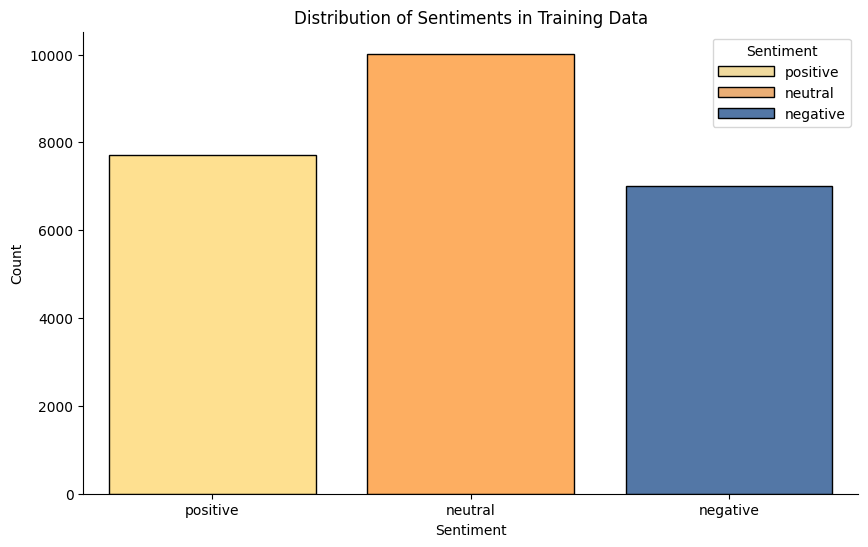

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.legend_handler import HandlerTuple
# Define the color palette with only as many colors as needed
unique_sentiments = train_data['sentiment'].unique()
palette = ["#fee090", "#fdae61", "#4575b4"][:len(unique_sentiments)]

# Plot the distribution of sentiments
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=train_data, x='sentiment', hue='sentiment', palette=palette, edgecolor='black', legend=True)

# Adjust the colors for each bar
for bars, colors in zip(ax.containers, (palette[0::2], palette[1::2])):
    for bar, color in zip(bars, colors):
        bar.set_facecolor(color)

# Customize the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, unique_sentiments, title='Sentiment', handlelength=4, handler_map={tuple: HandlerTuple(ndivide=None, pad=0.1)})

sns.despine()
plt.title('Distribution of Sentiments in Training Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

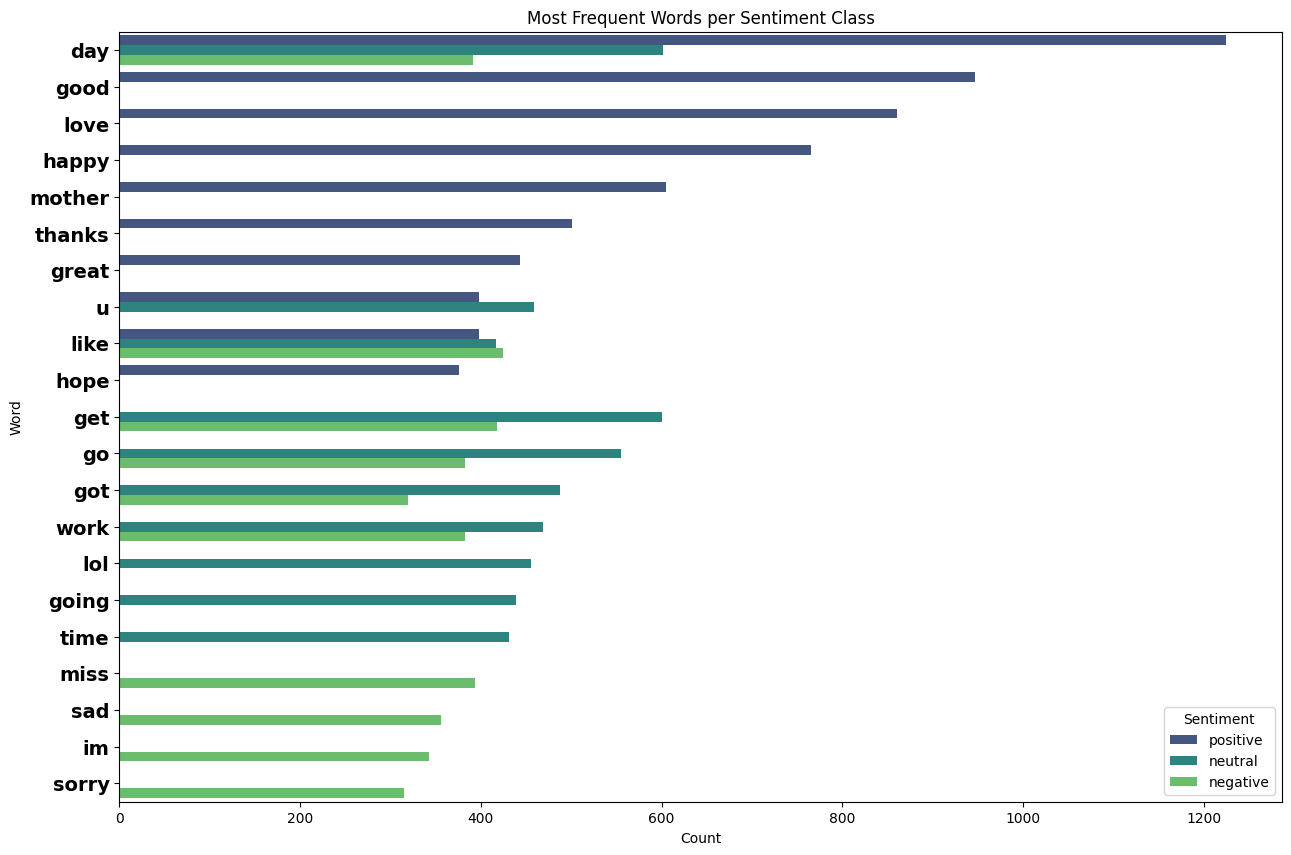

In [ ]:

from collections import Counter


# Function to get the most frequent words per class
def get_top_n_words(corpus, n=None):
    vec = Counter(corpus)
    return vec.most_common(n)

# Create a dataframe to store the most frequent words per sentiment class
top_words_per_class = pd.DataFrame(columns=["word", "count", "sentiment"])

# Get the most frequent words per sentiment class
rows = []
for sentiment in train_data["sentiment"].unique():
    words = []
    for text in train_data[train_data["sentiment"] == sentiment]["cleaned"]:
        words.extend(word_tokenize(text))
    top_words = get_top_n_words(words, 10)
    for word, count in top_words:
        rows.append({"word": word, "count": count, "sentiment": sentiment})

# Convert rows list to DataFrame
top_words_per_class = pd.DataFrame(rows)

# Plot the most frequent words per sentiment class
plt.figure(figsize=(15, 10))
sns.barplot(data=top_words_per_class, x="count", y="word", hue="sentiment", palette="viridis")
plt.title("Most Frequent Words per Sentiment Class")
plt.xlabel("Count")
plt.ylabel("Word")
plt.legend(title="Sentiment")
# Customize y-axis labels
plt.yticks(fontsize=14, fontweight='bold')
plt.show()


Text(0, 0.5, 'Frequency')

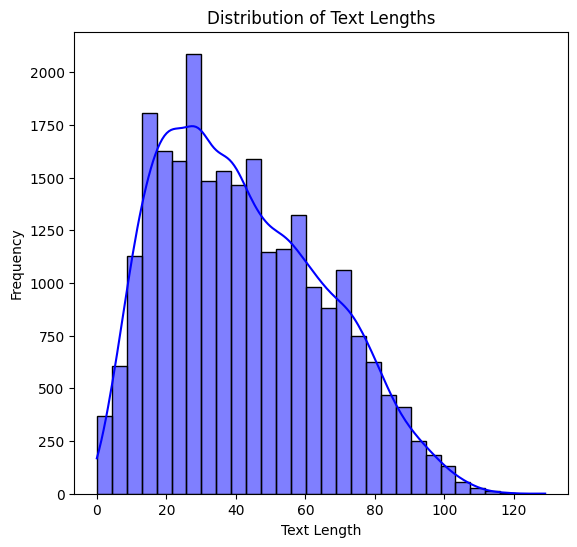

In [ ]:
train_data['text_length'] = train_data['cleaned'].apply(len)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(train_data['text_length'], kde=True, bins=30, color='blue')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')


<ipython-input-44-c057f1dd2f2a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_data, x='sentiment', y='text_length', palette='viridis')


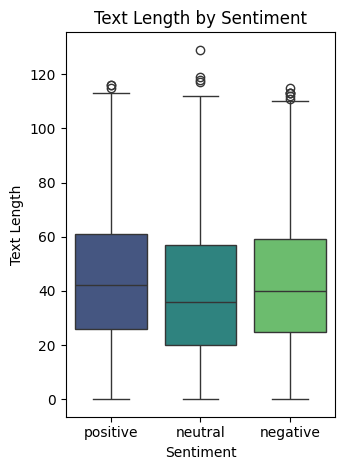

In [ ]:
plt.subplot(1, 2, 2)
sns.boxplot(data=train_data, x='sentiment', y='text_length', palette='viridis')
plt.title('Text Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Text Length')

plt.tight_layout()
plt.show()


In [ ]:
# Assuming 'df' is your existing DataFrame
traning_data=train_data.copy()
traning_data.reset_index(inplace=True)  # Reset the index to ensure it's unique and sequential
train_data['MyID'] = traning_data.index  # Create a new column 'MyID' which copies


# Splitting the data into 80% train and 20% remaining
training_data, remaining_data = train_test_split(train_data, test_size=0.3, random_state=42,stratify=train_data['sentiment'])

# Splitting the remaining 20% into half validation and half test (i.e., 10% of the total each)
valid_data, test_data = train_test_split(remaining_data, test_size=0.5, random_state=42,stratify=remaining_data['sentiment'])


In [ ]:
test_data

,ID,text,selected_text,sentiment,lower,cleaned,MyID
19049,0dc7783f19,"I know, I stink at birthdays sorry bra, hope...","I know, I stink at birthdays sorry bra, hope ...",neutral,i know i stink at birthdays sorry bra hope...,know stink birthday sorry bra hope fun anyhow ...,19048
20115,947c9ec438,Merlin wasn`t too bad. Already watched it on ...,Merlin wasn`t too bad. Already watched it on B...,neutral,merlin wasn t too bad already watched it on ...,merlin bad already watched bt course,20114
18648,80c625f274,vineri...nimic special sau probabil un alt wee...,vineri...nimic special sau probabil un alt wee...,neutral,vineri nimic special sau probabil un alt weeke...,vineri nimic special sau probabil un alt weeke...,18647
19682,bd062e271e,Reading and taking notes but undertanding none...,undertanding none of it ... HELP!,negative,reading and taking notes but undertanding none...,reading taking note undertanding none help,19681
5248,0605f9f6a9,"Very well thank you! How are you, more import...",Very well thank you!,positive,very well thank you how are you more import...,well thank importantly,5247
...,...,...,...,...,...,...,...
13177,e8e58c2976,Sum1 plz cheer me up,Sum1 plz cheer me up,neutral,sum1 plz cheer me up,sum1 plz cheer,13176
19161,f7b2b97d08,i have a yucky burn,yucky burn,negative,i have a yucky burn,yucky burn,19160
15694,992102ee7b,Its good to have an old friend at ur new job. ...,Another good day at work.,positive,its good to have an old friend at ur new job ...,good old friend ur new job another good day wo...,15693
1714,87ca113e24,"Alright, sorry. But I think you should go any...",sorry.,negative,alright sorry but i think you should go any...,alright sorry think go anyways,1713


In [ ]:
counter=0
for index, row in train_data.iterrows():
  counter+=1
  if counter>50:
    break
  if row["sentiment"]=="neutral":
    print(f"tweet: {row['lower']}, selected_text: {row['selected_text']}")

In [ ]:
import getpass
import os


def SetEnv(name):
    secret = getpass.getpass(f"Enter value of {name}: ")
    os.environ[name] = secret

# Usage to set var
SetEnv("OPENAI_API_KEY")
SetEnv("OPENAI_API_ORG")

Enter value of OPENAI_API_KEY: ··········
Enter value of OPENAI_API_ORG: ··········


In [ ]:
#@title openai class
import os
import openai
import pandas as pd
import logging
import json
import numpy as np
from tenacity import retry, wait_random_exponential, stop_after_attempt
from openai import OpenAI

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# Define the OpenAICaller class
class OpenAICaller:
    def __init__(self, model_name, temperature=None, api_key=None, organization=None):
        self._client = None
        self.api_key = api_key if api_key is not None else os.getenv('OPENAI_API_KEY')
        self.model_name = model_name
        self.organization = organization if organization is not None else os.getenv('OPENAI_API_ORG')
        self.temperature = temperature

    @property
    def client(self):
        if self._client is None:
            self._client = OpenAI(
                organization=self.organization,
                api_key=self.api_key,
            )
        return self._client

    @retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
    def get_embedding(self, text: str, model="text-embedding-3-small") -> list[float]:
        return self.client.embeddings.create(input=[text], model=model).data[0].embedding
    @retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
    def get_chat_completion(self, messages: list[dict]):
        response = self.client.chat.completions.create(model=self.model_name,
                                                       messages=messages,
                                                       temperature=self.temperature,
                                                       seed=2024, response_format={"type": "json_object"})
        logging.info(f"Num of tokens processed: {response.usage.total_tokens}")
        return response.choices[0].message.content

# Define the function to generate variations
def generate_question_variations(tweets, temperature, model_name="gpt-3.5-turbo"):
      # The structured input now expects a batch of tweets
      structured_input = json.dumps({i+1: tweet for i, tweet in enumerate(tweets)})
      messages=[
      {
        "role": "system",
        "content": "You are an expert in tweet sentiment analysis. "
        "I will give you a batch of tweets and I want you to return one word based on the sentiment. Positive, Negative or Neutral. along with the part of the tweet that you used to chose the sentiment "
        "You will return the values in json format, where the key is the index of the tweet and the value is a list containing the sentiment and the extracted words that you used to chose the sentiment "
      },
      {
      "role": "user",
      "content": json.dumps({
      1: "yay to being smokefree  well done",
      2: "i hope you hoes are having so much fun not too much without me though lol",
      3: "wow  that s looks really good  i wish i had some  was it good",
      4: "i miss my friends so much",
      5: "i think i d be like phoebe s mom on friends   stop the movie before the sad part ",
      6: "can t sleep   feening for cigs  i m horrible   x" ,
      7: "hmm you can t judge a book by looking at its cover",
      8:  "says finally  im home   http plurk com p rr121",
      9: "talking to nat"
      })
      },
      {
      "role": "assistant",
      "content": json.dumps({
      1: ["positive", "yay well done"],
      2: ["positive", "so much fun"],
      3: ["positive", "really good"],
      4: ["negative, I miss my friends so much"],
      5: ["neagtive","sad"],
      6: ["negative","horrible"],
      7: ["neutral","Hmm..You can`t judge a book by looking at its cover"],
      8: ["neutral","says Finally, Im home."],
      9: ["neutral","talking to nat"]
      })
      },
      {
      "role": "user",
      "content": structured_input

      }
    ]


    # Initialize OpenAICaller and get the response
      openai_caller = OpenAICaller(model_name, temperature)
      response = openai_caller.get_chat_completion(messages)

      try:
          response_dict = json.loads(response)
      except json.JSONDecodeError as e:
          print(f"JSON decode error: {e}")
          response_dict = {}

      return response_dict

# Define function to calculate similarity between original and generated questions
def calculate_embedding(tweet, model_name="text-embedding-3-large"):
    openai_caller = OpenAICaller(model_name)
    tweet_embedding = openai_caller.get_embedding(tweet, model_name)
    return tweet_embedding



In [ ]:
from tqdm import tqdm
import pandas as pd

# Assuming calculate_embedding is already defined

# Wrap the apply function with tqdm progress bar
tqdm.pandas()

# Apply the calculate_embedding function with progress bar
train_data['similarities'] = train_data['lower'].progress_apply(calculate_embedding)
train_data.to_pickle('/content/drive/MyDrive/AML/challenge3/train_data_embeddings.pkl')

val_data['similarities'] = val_data['lower'].progress_apply(calculate_embedding)
val_data.to_pickle('/content/drive/MyDrive/AML/challenge3/val_data_embeddings.pkl')


100%|██████████| 2748/2748 [17:32<00:00,  2.61it/s]


In [ ]:
structured_input = json.dumps({
    10: "This new product launch is amazing!",
    11: "Such terrible service at the restaurant last night.",
    12: "I'm undecided about the new policy changes."
})

temperature = None
# model_name = "gpt-4o"
model_name = "gpt-4o"
response_dict = generate_question_variations(structured_input, temperature, model_name)

# Print the output
for key, value in response_dict.items():
    print(f"{key}: {value}")

10: ['positive', 'amazing']
11: ['negative', 'terrible service']
12: ['neutral', 'undecided about the new policy changes']


In [ ]:
test_data

NameError: name 'test_data' is not defined

In [ ]:
batch_size = 15
temperature = 0
model_name = "gpt-4o"
variations_df = pd.DataFrame(columns=['ID', 'Tweet', 'Predicted_Sentiment', 'Extracted_Part', 'True_Sentiment', 'Original_Extracted_Text'])

# Process in batches
for i in range(0, len(test_data), batch_size):
    print(f"batch number: {i}")
    # Ensure the batch only contains as many tweets as are available
    batch_end = min(i + batch_size, len(test_data))
    batch_tweets = test_data['text'][i:batch_end].tolist()
    true_sentiments = test_data['sentiment'][i:batch_end].tolist()
    original_texts = test_data['selected_text'][i:batch_end].tolist()  # Extracting original extracted texts for the batch
    response_dict = generate_question_variations(batch_tweets, temperature, model_name)

    # Process each response in the batch
    for j in range(0, batch_end - i):  # Corrected to iterate through the actual batch size
        true_sentiment = true_sentiments[j]
        sentiment = response_dict[str(j+1)][0]
        extracted_part = response_dict[str(j+1)][1]
        original_text = original_texts[j]  # Get the original selected text
        tweet_index = i + j  # Correct index in the original DataFrame
        new_row = {
            'ID': tweet_index,
            'Tweet': batch_tweets[j],
            'Predicted_Sentiment': sentiment,  # Assuming the first item is sentiment
            'Extracted_Part': extracted_part,  # Assuming the second item is the extracted part
            'True_Sentiment': true_sentiment,
            'Original_Extracted_Text': original_text
        }
        variations_df = pd.concat([variations_df, pd.DataFrame([new_row])], ignore_index=True)


batch number: 0
batch number: 15
batch number: 30
batch number: 45
batch number: 60
batch number: 75
batch number: 90
batch number: 105
batch number: 120
batch number: 135
batch number: 150
batch number: 165
batch number: 180
batch number: 195
batch number: 210
batch number: 225
batch number: 240
batch number: 255
batch number: 270
batch number: 285
batch number: 300
batch number: 315
batch number: 330
batch number: 345
batch number: 360
batch number: 375
batch number: 390
batch number: 405
batch number: 420
batch number: 435
batch number: 450
batch number: 465
batch number: 480
batch number: 495
batch number: 510
batch number: 525
batch number: 540
batch number: 555
batch number: 570
batch number: 585
batch number: 600
batch number: 615
batch number: 630
batch number: 645
batch number: 660
batch number: 675
batch number: 690
batch number: 705
batch number: 720
batch number: 735
batch number: 750
batch number: 765
batch number: 780
batch number: 795
batch number: 810
batch number: 825


In [ ]:
test_data=val_data.copy()

In [ ]:
#@title for val_data unlabelled
batch_size = 40
temperature = 0
model_name = "gpt-4o"
variations_df = pd.DataFrame(columns=['ID', 'Tweet', 'Predicted_Sentiment', 'Extracted_Part', 'Original_Extracted_Text'])

# Process in batches
for i in range(0, len(test_data), batch_size):
    print(f"batch number: {i}")
    # Ensure the batch only contains as many tweets as are available
    batch_end = min(i + batch_size, len(test_data))
    batch_tweets = test_data['lower'][i:batch_end].tolist()
    # true_sentiments = test_data['sentiment'][i:batch_end].tolist()
    original_texts = test_data['selected_text'][i:batch_end].tolist()  # Extracting original extracted texts for the batch
    response_dict = generate_question_variations(batch_tweets, temperature, model_name)

    # Process each response in the batch
    for j in range(0, batch_end - i):  # Corrected to iterate through the actual batch size
        # true_sentiment = true_sentiments[j]
        sentiment = response_dict[str(j+1)][0]
        extracted_part = response_dict[str(j+1)][1]
        original_text = original_texts[j]  # Get the original selected text
        tweet_index = i + j  # Correct index in the original DataFrame
        new_row = {
            'ID': tweet_index,
            'Tweet': batch_tweets[j],
            'Predicted_Sentiment': sentiment,  # Assuming the first item is sentiment
            'Extracted_Part': extracted_part,  # Assuming the second item is the extracted part
            'Original_Extracted_Text': original_text
        }
        variations_df = pd.concat([variations_df, pd.DataFrame([new_row])], ignore_index=True)


batch number: 0
batch number: 40
batch number: 80
batch number: 120
batch number: 160
batch number: 200
batch number: 240
batch number: 280
batch number: 320
batch number: 360
batch number: 400
batch number: 440
batch number: 480
batch number: 520
batch number: 560
batch number: 600
batch number: 640
batch number: 680
batch number: 720
batch number: 760
batch number: 800
batch number: 840
batch number: 880
batch number: 920
batch number: 960
batch number: 1000
batch number: 1040
batch number: 1080
batch number: 1120
batch number: 1160
batch number: 1200
batch number: 1240
batch number: 1280
batch number: 1320
batch number: 1360
batch number: 1400
batch number: 1440
batch number: 1480
batch number: 1520
batch number: 1560
batch number: 1600
batch number: 1640
batch number: 1680
batch number: 1720
batch number: 1760
batch number: 1800
batch number: 1840
batch number: 1880
batch number: 1920
batch number: 1960
batch number: 2000
batch number: 2040
batch number: 2080
batch number: 2120
bat

In [ ]:
#@title old
batch_size = 6
temperature = 0
model_name = "gpt-4o"
variations_df = pd.DataFrame(columns=['ID', 'Tweet', 'Predicted_Sentiment', 'Extracted_Part', 'True_Sentiment', 'Original_Extracted_Text'])

# Process in batches
for i in range(0, len(test_data), batch_size):
    # Ensure the batch only contains as many tweets as are available
    batch_end = min(i + batch_size, len(test_data))
    batch_tweets = test_data['lower'][i:batch_end].tolist()
    true_sentiments = test_data['sentiment'][i:batch_end].tolist()
    original_texts = test_data['selected_text'][i:batch_end].tolist()  # Extracting original extracted texts for the batch
    response_dict = generate_question_variations(batch_tweets, temperature, model_name)

    # Process each response in the batch
    for j in range(1,batch_size):
        true_sentiment = true_sentiments[j-1]
        sentiment=response_dict[str(j)][0]
        extracted_part=response_dict[str(j)][1]
        original_text = original_texts[j-1]  # Get the original selected text
        tweet_index = i + j-1 # Correct index in the original DataFrame
        new_row = {
            'ID': tweet_index,
            'Tweet': batch_tweets[j-1],
            'Predicted_Sentiment': sentiment,  # Assuming the first item is sentiment
            'Extracted_Part': extracted_part,  # Assuming the second item is the extracted part
            'True_Sentiment': true_sentiment,
            'Original_Extracted_Text': original_text
        }
        variations_df = pd.concat([variations_df, pd.DataFrame([new_row])], ignore_index=True)


In [ ]:
variations_df

,ID,Tweet,Predicted_Sentiment,Extracted_Part,True_Sentiment,Original_Extracted_Text
0,0,i know i stink at birthdays sorry bra hope...,negative,sorry bra,neutral,"I know, I stink at birthdays sorry bra, hope ..."
1,1,merlin wasn t too bad already watched it on ...,neutral,wasn't too bad,neutral,Merlin wasn`t too bad. Already watched it on B...
2,2,vineri nimic special sau probabil un alt weeke...,negative,nimic special,neutral,vineri...nimic special sau probabil un alt wee...
3,3,reading and taking notes but undertanding none...,negative,undertanding none of it,negative,undertanding none of it ... HELP!
4,4,very well thank you how are you more import...,neutral,very well thank you,positive,Very well thank you!
...,...,...,...,...,...,...
3705,3705,sum1 plz cheer me up,negative,cheer me up,neutral,Sum1 plz cheer me up
3706,3706,i have a yucky burn,negative,yucky burn,negative,yucky burn
3707,3707,its good to have an old friend at ur new job ...,positive,good day at work,positive,Another good day at work.
3708,3708,alright sorry but i think you should go any...,neutral,sorry,negative,sorry.


In [ ]:
variations_df.to_pickle('/content/drive/MyDrive/AML/challenge3/gpt4-o_test_set_predictions_orginal_tweet.pkl')

In [ ]:
variations_df=pd.read_pickle('/content/drive/MyDrive/AML/challenge3/gpt4-o_test_set_predictions_orginal_tweet.pkl')

In [ ]:
# Filtering rows where predicted sentiment is different from the true sentiment
filtered_df = variations_df[variations_df['Predicted_Sentiment'] != variations_df['True_Sentiment']]

# Selecting the required columns
result = filtered_df[['Tweet', 'Predicted_Sentiment', 'True_Sentiment']]

# Iterate through rows and print the ones where predicted sentiment is different from true sentiment
for index, row in result.iterrows():
    if row['Predicted_Sentiment'] != row['True_Sentiment']:
        print(f"Tweet: {row['Tweet']}\nPredicted Sentiment: {row['Predicted_Sentiment']}\nTrue Sentiment: {row['True_Sentiment']}\n")

Tweet:  I know, I stink at birthdays  sorry bra, hope you`re having fun anyhow, in spite of me!
Predicted Sentiment: negative
True Sentiment: neutral

Tweet: vineri...nimic special sau probabil un alt weekend pierdut...
Predicted Sentiment: negative
True Sentiment: neutral

Tweet: I wish GM stock would turn around at 80 cents a share I would be willing to buy some...if I knew it would do something
Predicted Sentiment: neutral
True Sentiment: positive

Tweet:  Thanks Elaine. I`m clipping reviews for her scrapbook.
Predicted Sentiment: neutral
True Sentiment: positive

Tweet: At my cousins wake
Predicted Sentiment: negative
True Sentiment: neutral

Tweet: _says ha ha funny
Predicted Sentiment: neutral
True Sentiment: positive

Tweet: Beer, garden, IPOD, Friday night, shame I`ve got to work tomorrow
Predicted Sentiment: negative
True Sentiment: neutral

Tweet:  Poor you   If I was with you right now; I would probably give you a hug ;D
Predicted Sentiment: positive
True Sentiment: neutral


In [ ]:
#@title 4o Perfomance on test set with orginal tweets

y_true = variations_df['True_Sentiment']
y_pred = variations_df['Predicted_Sentiment']

report = classification_report(y_true, y_pred)

print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

    negative       0.69      0.82      0.75      1051
     neutral       0.71      0.61      0.66      1503
    positive       0.75      0.76      0.75      1156

    accuracy                           0.72      3710
   macro avg       0.72      0.73      0.72      3710
weighted avg       0.72      0.72      0.71      3710



In [ ]:
#@title 3.5-turbo Perfomance on test set with orginal tweets

y_true = variations_df['True_Sentiment']
y_pred = variations_df['Predicted_Sentiment']

report = classification_report(y_true, y_pred)

print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

    negative       0.68      0.81      0.74      1051
     neutral       0.71      0.54      0.61      1503
    positive       0.69      0.79      0.74      1156

    accuracy                           0.69      3710
   macro avg       0.69      0.71      0.70      3710
weighted avg       0.69      0.69      0.69      3710



In [ ]:
#@title GPT4o Perfomance on test set

y_true = variations_df['True_Sentiment']
y_pred = variations_df['Predicted_Sentiment']

report = classification_report(y_true, y_pred)

print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

    negative       0.69      0.79      0.73      1051
     neutral       0.69      0.63      0.66      1503
    positive       0.76      0.74      0.75      1156

    accuracy                           0.71      3710
   macro avg       0.71      0.72      0.71      3710
weighted avg       0.71      0.71      0.71      3710



In [ ]:
# from sklearn.preprocessing import StandardScaler

# Define the normalize_l2 function
def normalize_l2(x):
    x = np.array(x)
    if x.ndim == 1:
        norm = np.linalg.norm(x)
        if norm == 0:
            return x
        return x / norm
    else:
        norm = np.linalg.norm(x, 2, axis=1, keepdims=True)
        return np.where(norm == 0, x, x / norm)

# Normalize the first 256 dimensions of each embedding
def process_embedding(embedding):
    cut_dim = embedding[:128]
    norm_dim = normalize_l2(cut_dim)
    return norm_dim


# Assuming embeddings_train is your DataFrame containing the 'similarities' and 'sentiment' columns.
only_embeddings_train = embeddings_train[["similarities", "sentiment"]]
only_embeddings_valid=labeled_val[["similarities", "Predicted_Sentiment"]]

X_unlabeled=np.vstack(only_embeddings_valid["similarities"].values)
y_unlabeled=only_embeddings_valid["Predicted_Sentiment"].values

# Ensure that the similarities column is properly formatted as a numpy array
X = np.vstack(only_embeddings_train["similarities"].values)  # Stack the list of arrays into a 2D array
y = only_embeddings_train["sentiment"].values

##This is to truncate the embeddings just to see how it would work.
# Apply the function to all embeddings
# embeddings_normalized = np.array([process_embedding(embedding) for embedding in X])
# print(embeddings_normalized.shape)


# Splitting the data into 80% train and 20% remaining
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Splitting the remaining 20% into half validation and half test (i.e., 10% of the total each)
X_valid, X_test, y_valid, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42, stratify=y_remaining)

# Displaying the shapes of the resulting splits
print(f"Training data shapes: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation data shapes: X_valid: {X_valid.shape}, y_valid: {y_valid.shape}")
print(f"Test data shapes: X_test: {X_test.shape}, y_test: {y_test.shape}")


# scaler = StandardScaler()
# # Don't cheat - fit only on training data
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# # apply same transformation to valid data
# X_valid = scaler.transform(X_valid)
# # apply same transformation to test data
# X_test = scaler.transform(X_test)

Training data shapes: X_train: (17312, 3072), y_train: (17312,)
Validation data shapes: X_valid: (3710, 3072), y_valid: (3710,)
Test data shapes: X_test: (3710, 3072), y_test: (3710,)


In [ ]:
!pip install --extra-index-url=https://pypi.nvidia.com cuml-cu12==24.4.*

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 363.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.6/126.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 MB 371.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.1/170.1 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 810.9/810.9 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 87.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 24.8 MB/s eta 0:00:00
  Attempting uninstall: dask
    Found e

In [ ]:
import cuml
from cuml.neighbors import NearestNeighbors,KNeighborsClassifier
from cuml.metrics import pairwise_distances
from cuml.metrics import accuracy_score
from sklearn.metrics import classification_report, f1_score
import numpy as np
import cudf
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import cupy

label_mapping = {'neutral': 0, 'positive': 1, 'negative': 2}

# Convert data to cuDF dataframes if not already in that format
# X_train_cudf = cudf.DataFrame.from_pandas(pd.DataFrame(X_train))
# X_valid_cudf = cudf.DataFrame.from_pandas(pd.DataFrame(X_valid))
# X_unlabeled_cudf = cudf.DataFrame.from_pandas(pd.DataFrame(X_unlabeled))
# y_unlabeled_cudf = cudf.Series(y_unlabeled).map(label_mapping)
# y_train_cudf = cudf.Series(y_train).map(label_mapping)
# y_valid_cudf = cudf.Series(y_valid).map(label_mapping)

#Initialize the KNN classifier with cosine similarity
knn = KNeighborsClassifier(n_neighbors=200, metric='cosine')
knn.fit(X_train_cudf,y_train_cudf)

# Find the k-neighbors
y_pred= knn.predict(X_valid_cudf)

# Convert y_valid_cudf and y_pred to numpy arrays
y_valid_np = y_valid_cudf.to_numpy()
y_pred_np = y_pred.to_numpy()

# Evaluate the classifier
print(classification_report(y_valid_np, y_pred_np))
print("Accuracy:", accuracy_score(y_valid_np, y_pred_np))


              precision    recall  f1-score   support

           0       0.69      0.65      0.67      1503
           1       0.73      0.77      0.75      1157
           2       0.72      0.73      0.73      1050

    accuracy                           0.71      3710
   macro avg       0.71      0.72      0.72      3710
weighted avg       0.71      0.71      0.71      3710

Accuracy: 0.7115902900695801


In [ ]:
# Find the k-neighbors
y_pred= knn.predict(X_unlabeled_cudf)

# Convert y_valid_cudf and y_pred to numpy arrays
y_unlabeled_np = y_unlabeled_cudf.to_numpy()
y_pred_np = y_pred.to_numpy()

# Evaluate the classifier
print(classification_report(y_unlabeled_np, y_pred_np))
print("Accuracy:", accuracy_score(y_unlabeled_np, y_pred_np))

              precision    recall  f1-score   support

           0       0.65      0.74      0.69       975
           1       0.77      0.79      0.78       848
           2       0.87      0.70      0.78       925

    accuracy                           0.74      2748
   macro avg       0.76      0.75      0.75      2748
weighted avg       0.76      0.74      0.75      2748

Accuracy: 0.7445414662361145


In [ ]:
# Hyperparameter tuning
best_f1 = 0
best_n_neighbors = 0
for n_neighbors in range(1, 600, 50):  # Adjust the range and step as needed
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train_cudf, y_train_cudf)

    # Find the k-neighbors
    y_pred = knn.predict(X_valid_cudf)

    # Convert y_valid_cudf and y_pred to numpy arrays
    y_valid_np = y_valid_cudf.to_numpy()
    y_pred_np = y_pred.to_numpy()

    # Calculate macro average F1 score
    f1 = f1_score(y_valid_np, y_pred_np, average='macro')

    if f1 > best_f1:
        best_f1 = f1
        best_n_neighbors = n_neighbors

    print(f"n_neighbors: {n_neighbors}, Macro Avg F1 Score: {f1}")

print(f"Best n_neighbors: {best_n_neighbors}, Best Macro Avg F1 Score: {best_f1}")

# Evaluate the classifier with the best n_neighbors
knn = KNeighborsClassifier(n_neighbors=best_n_neighbors, metric='cosine')
knn.fit(X_train_cudf, y_train_cudf)
y_pred = knn.predict(X_valid_cudf)
y_valid_np = y_valid_cudf.to_numpy()
y_pred_np = y_pred.to_numpy()

# Evaluate the classifier
print(classification_report(y_valid_np, y_pred_np))
print("Accuracy:", accuracy_score(y_valid_np, y_pred_np))

n_neighbors: 1, Macro Avg F1 Score: 0.5940071608289693
n_neighbors: 51, Macro Avg F1 Score: 0.6991106288130519
n_neighbors: 101, Macro Avg F1 Score: 0.7094567480016325
n_neighbors: 151, Macro Avg F1 Score: 0.710620087199449
n_neighbors: 201, Macro Avg F1 Score: 0.7156691201682558
n_neighbors: 251, Macro Avg F1 Score: 0.7155708358108833
n_neighbors: 301, Macro Avg F1 Score: 0.7109097253034601
n_neighbors: 351, Macro Avg F1 Score: 0.71591172705432
n_neighbors: 401, Macro Avg F1 Score: 0.7161899294157852
n_neighbors: 451, Macro Avg F1 Score: 0.7161155602323589
n_neighbors: 501, Macro Avg F1 Score: 0.7141793524944706
n_neighbors: 551, Macro Avg F1 Score: 0.7175904008286403
Best n_neighbors: 551, Best Macro Avg F1 Score: 0.7175904008286403
              precision    recall  f1-score   support

           0       0.68      0.67      0.67      1503
           1       0.74      0.77      0.75      1157
           2       0.73      0.71      0.72      1050

    accuracy                         

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
preds = clf.predict(X_valid)
print(classification_report(y_valid,preds))

              precision    recall  f1-score   support

    negative       0.76      0.58      0.66      1050
     neutral       0.60      0.80      0.68      1503
    positive       0.82      0.63      0.71      1157

    accuracy                           0.69      3710
   macro avg       0.73      0.67      0.68      3710
weighted avg       0.71      0.69      0.69      3710



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encoding the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_valid)
y_test_encoded = label_encoder.transform(y_test)

# Converting labels to categorical (one-hot encoding)
y_train_categorical = tf.keras.utils.to_categorical(y_train_encoded, num_classes=3)
y_valid_categorical = tf.keras.utils.to_categorical(y_valid_encoded, num_classes=3)
y_test_categorical = tf.keras.utils.to_categorical(y_test_encoded, num_classes=3)

# Building the MLP model
model = Sequential()
model.add(Dense(512, input_dim=3072, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(X_train, y_train_categorical, validation_data=(X_valid, y_valid_categorical), epochs=50, batch_size=64)

# Evaluating the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predicting on the test set
preds = model.predict(X_test)
predicted_classes = tf.argmax(preds, axis=1)

# Converting predictions and true labels back to original encoding
predicted_labels = label_encoder.inverse_transform(predicted_classes)
true_labels = label_encoder.inverse_transform(tf.argmax(y_test_categorical, axis=1))

# Printing classification report
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels))


Epoch 1/50
271/271 [==============================] - 7s 8ms/step - loss: 0.6654 - accuracy: 0.7036 - val_loss: 0.5534 - val_accuracy: 0.7639
Epoch 2/50
271/271 [==============================] - 1s 5ms/step - loss: 0.5553 - accuracy: 0.7663 - val_loss: 0.5511 - val_accuracy: 0.7650
Epoch 3/50
271/271 [==============================] - 1s 5ms/step - loss: 0.5150 - accuracy: 0.7822 - val_loss: 0.5556 - val_accuracy: 0.7650
Epoch 4/50
271/271 [==============================] - 1s 5ms/step - loss: 0.4830 - accuracy: 0.8053 - val_loss: 0.5377 - val_accuracy: 0.7693
Epoch 5/50
271/271 [==============================] - 1s 5ms/step - loss: 0.4283 - accuracy: 0.8246 - val_loss: 0.5553 - val_accuracy: 0.7625
Epoch 6/50
271/271 [==============================] - 1s 5ms/step - loss: 0.3854 - accuracy: 0.8464 - val_loss: 0.5771 - val_accuracy: 0.7666
Epoch 7/50
271/271 [==============================] - 3s 9ms/step - loss: 0.3413 - accuracy: 0.8633 - val_loss: 0.6103 - val_accuracy: 0.7658
Epoch 

In [ ]:
#@title unlabeled valid set
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encoding the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_valid)
y_test_encoded = label_encoder.transform(y_test)
y_unlabeled_encoded = label_encoder.transform(y_unlabeled)

# Converting labels to categorical (one-hot encoding)
y_train_categorical = tf.keras.utils.to_categorical(y_train_encoded, num_classes=3)
y_valid_categorical = tf.keras.utils.to_categorical(y_valid_encoded, num_classes=3)
y_test_categorical = tf.keras.utils.to_categorical(y_test_encoded, num_classes=3)
y_unlabeled_categorical = tf.keras.utils.to_categorical(y_unlabeled_encoded, num_classes=3)

# Building the MLP model
model = Sequential()
model.add(Dense(512, input_dim=3072, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(X_train, y_train_categorical, validation_data=(X_valid, y_valid_categorical), epochs=4, batch_size=64)

# Evaluating the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predicting on the test set
preds = model.predict(X_unlabeled)
predicted_classes = tf.argmax(preds, axis=1)

# Converting predictions and true labels back to original encoding
predicted_labels = label_encoder.inverse_transform(predicted_classes)
true_labels = label_encoder.inverse_transform(tf.argmax(y_test_categorical, axis=1))

# Printing classification report
from sklearn.metrics import classification_report
print(classification_report(y_unlabeled, predicted_labels))


Epoch 1/4
271/271 [==============================] - 10s 31ms/step - loss: 0.6685 - accuracy: 0.7032 - val_loss: 0.5581 - val_accuracy: 0.7644
Epoch 2/4
271/271 [==============================] - 9s 34ms/step - loss: 0.5561 - accuracy: 0.7635 - val_loss: 0.5825 - val_accuracy: 0.7461
Epoch 3/4
271/271 [==============================] - 8s 29ms/step - loss: 0.5179 - accuracy: 0.7819 - val_loss: 0.5356 - val_accuracy: 0.7701
Epoch 4/4
116/116 [==============================] - 1s 7ms/step - loss: 0.5618 - accuracy: 0.7660
Test Accuracy: 0.7660
86/86 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

    negative       0.82      0.73      0.78       925
     neutral       0.65      0.73      0.69       975
    positive       0.81      0.79      0.80       848

    accuracy                           0.75      2748
   macro avg       0.76      0.75      0.76      2748
weighted avg       0.76      0.75      0.75      2748



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Encoding the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_valid)
y_test_encoded = label_encoder.transform(y_test)

# Converting labels to categorical (one-hot encoding)
y_train_categorical = tf.keras.utils.to_categorical(y_train_encoded, num_classes=3)
y_valid_categorical = tf.keras.utils.to_categorical(y_valid_encoded, num_classes=3)
y_test_categorical = tf.keras.utils.to_categorical(y_test_encoded, num_classes=3)

# Building the MLP model with regularization
model = Sequential()
model.add(Dense(256, input_dim=3072, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dropout(0.6))
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dropout(0.6))
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dense(3, activation='softmax'))

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# # Adding early stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model
history = model.fit(X_train, y_train_categorical, validation_data=(X_valid, y_valid_categorical),
                    epochs=100, batch_size=32)#callbacks=[early_stopping]

# Evaluating the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predicting on the test set
preds = model.predict(X_test)
predicted_classes = tf.argmax(preds, axis=1)

# Converting predictions and true labels back to original encoding
predicted_labels = label_encoder.inverse_transform(predicted_classes)
true_labels = label_encoder.inverse_transform(tf.argmax(y_test_categorical, axis=1))

# Printing classification report
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels))


Num GPUs Available:  1
Epoch 1/100
541/541 [==============================] - 9s 10ms/step - loss: 1.6656 - accuracy: 0.6029 - val_loss: 1.3758 - val_accuracy: 0.7391
Epoch 2/100
541/541 [==============================] - 4s 7ms/step - loss: 1.4279 - accuracy: 0.6890 - val_loss: 1.2927 - val_accuracy: 0.7577
Epoch 3/100
541/541 [==============================] - 2s 4ms/step - loss: 1.2969 - accuracy: 0.7288 - val_loss: 1.2055 - val_accuracy: 0.7620
Epoch 4/100
541/541 [==============================] - 2s 4ms/step - loss: 1.1903 - accuracy: 0.7485 - val_loss: 1.1226 - val_accuracy: 0.7655
Epoch 5/100
541/541 [==============================] - 2s 4ms/step - loss: 1.0901 - accuracy: 0.7543 - val_loss: 1.0547 - val_accuracy: 0.7671
Epoch 6/100
541/541 [==============================] - 3s 6ms/step - loss: 1.0096 - accuracy: 0.7633 - val_loss: 0.9803 - val_accuracy: 0.7690
Epoch 7/100
541/541 [==============================] - 3s 5ms/step - loss: 0.9357 - accuracy: 0.7730 - val_loss: 0.942

In [ ]:
#@title with 256 dimentions of embeddings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Encoding the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_valid)
y_test_encoded = label_encoder.transform(y_test)

# Converting labels to categorical (one-hot encoding)
y_train_categorical = tf.keras.utils.to_categorical(y_train_encoded, num_classes=3)
y_valid_categorical = tf.keras.utils.to_categorical(y_valid_encoded, num_classes=3)
y_test_categorical = tf.keras.utils.to_categorical(y_test_encoded, num_classes=3)

# Building the MLP model with regularization
model = Sequential()
model.add(Dense(128, input_dim=256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dropout(0.6))
model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dropout(0.6))
model.add(Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dense(3, activation='softmax'))

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# # Adding early stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model
history = model.fit(X_train, y_train_categorical, validation_data=(X_valid, y_valid_categorical),
                    epochs=100, batch_size=32)#callbacks=[early_stopping]

# Evaluating the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predicting on the test set
preds = model.predict(X_test)
predicted_classes = tf.argmax(preds, axis=1)

# Converting predictions and true labels back to original encoding
predicted_labels = label_encoder.inverse_transform(predicted_classes)
true_labels = label_encoder.inverse_transform(tf.argmax(y_test_categorical, axis=1))

# Printing classification report
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels))


Num GPUs Available:  1
Epoch 1/100
541/541 [==============================] - 6s 4ms/step - loss: 1.1195 - accuracy: 0.5309 - val_loss: 0.8499 - val_accuracy: 0.6857
Epoch 2/100
541/541 [==============================] - 3s 5ms/step - loss: 0.8653 - accuracy: 0.6771 - val_loss: 0.7757 - val_accuracy: 0.7119
Epoch 3/100
541/541 [==============================] - 3s 6ms/step - loss: 0.8058 - accuracy: 0.6957 - val_loss: 0.7470 - val_accuracy: 0.7199
Epoch 4/100
541/541 [==============================] - 2s 4ms/step - loss: 0.7782 - accuracy: 0.7015 - val_loss: 0.7214 - val_accuracy: 0.7272
Epoch 5/100
541/541 [==============================] - 2s 4ms/step - loss: 0.7558 - accuracy: 0.7131 - val_loss: 0.7154 - val_accuracy: 0.7245
Epoch 6/100
541/541 [==============================] - 2s 4ms/step - loss: 0.7413 - accuracy: 0.7183 - val_loss: 0.7015 - val_accuracy: 0.7286
Epoch 7/100
541/541 [==============================] - 2s 4ms/step - loss: 0.7349 - accuracy: 0.7159 - val_loss: 0.7020

In [ ]:
# Sample DataFrame
# Define phrases for each sentiment
positive_phrases = ["Positive"]
negative_phrases = ["Negative"]
neutral_phrases = ["Neutral"]

# Get embeddings for each phrase
positive_embeddings = [calculate_embedding(phrase) for phrase in positive_phrases]
negative_embeddings = [calculate_embedding(phrase) for phrase in negative_phrases]
neutral_embeddings = [calculate_embedding(phrase) for phrase in neutral_phrases]


# Compute average embeddings for each sentiment
def average_embedding(embeddings):
    return np.mean(embeddings, axis=0)

avg_positive_embedding = average_embedding(positive_embeddings)
avg_negative_embedding = average_embedding(negative_embeddings)
avg_neutral_embedding = average_embedding(neutral_embeddings)

# Function to classify embeddings based on sentiment
def classify_embedding(review_embedding, pos_embed, neg_embed, neu_embed):
    positive_score = cosine_similarity(review_embedding, pos_embed)
    negative_score = cosine_similarity(review_embedding, neg_embed)
    neutral_score = cosine_similarity(review_embedding, neu_embed)

    if positive_score > max(negative_score, neutral_score):
        return 'positive'
    elif negative_score > max(positive_score, neutral_score):
        return 'negative'
    else:
        return 'neutral'

predictions = []
for embedding in X_test:
    prediction = classify_embedding(embedding, avg_positive_embedding, avg_negative_embedding, avg_neutral_embedding)
    predictions.append(prediction)

# Convert predictions to numpy array
predictions = np.array(predictions)

# Evaluate the performance
from sklearn.metrics import classification_report

# Convert y_test to sentiment labels if they are numeric
# Assuming y_test has labels {1, 2, 4, 5} as in your original dataset

print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

    negative       0.57      0.86      0.68      1051
     neutral       0.59      0.16      0.26      1503
    positive       0.55      0.81      0.65      1156

    accuracy                           0.56      3710
   macro avg       0.57      0.61      0.53      3710
weighted avg       0.57      0.56      0.50      3710



In [ ]:
#@title unlablled data
# Sample DataFrame
# Define phrases for each sentiment
positive_phrases = ["Positive"]
negative_phrases = ["Negative"]
neutral_phrases = ["Neutral"]

# Get embeddings for each phrase
positive_embeddings = [calculate_embedding(phrase) for phrase in positive_phrases]
negative_embeddings = [calculate_embedding(phrase) for phrase in negative_phrases]
neutral_embeddings = [calculate_embedding(phrase) for phrase in neutral_phrases]


# Compute average embeddings for each sentiment
def average_embedding(embeddings):
    return np.mean(embeddings, axis=0)

avg_positive_embedding = average_embedding(positive_embeddings)
avg_negative_embedding = average_embedding(negative_embeddings)
avg_neutral_embedding = average_embedding(neutral_embeddings)

# Function to classify embeddings based on sentiment
def classify_embedding(review_embedding, pos_embed, neg_embed, neu_embed):
    positive_score = cosine_similarity(review_embedding, pos_embed)
    negative_score = cosine_similarity(review_embedding, neg_embed)
    neutral_score = cosine_similarity(review_embedding, neu_embed)

    if positive_score > max(negative_score, neutral_score):
        return 'positive'
    elif negative_score > max(positive_score, neutral_score):
        return 'negative'
    else:
        return 'neutral'

predictions = []
for embedding in X_unlabeled:
    prediction = classify_embedding(embedding, avg_positive_embedding, avg_negative_embedding, avg_neutral_embedding)
    predictions.append(prediction)

# Convert predictions to numpy array
predictions = np.array(predictions)

# Evaluate the performance
from sklearn.metrics import classification_report

# Convert y_test to sentiment labels if they are numeric
# Assuming y_test has labels {1, 2, 4, 5} as in your original dataset

print(classification_report(y_unlabeled, predictions))


              precision    recall  f1-score   support

    negative       0.81      0.51      0.63       925
     neutral       0.57      0.42      0.48       975
    positive       0.53      0.91      0.67       848

    accuracy                           0.60      2748
   macro avg       0.64      0.61      0.59      2748
weighted avg       0.64      0.60      0.59      2748



In [ ]:
# Sample DataFrame
positive_phrases = [
    "I am extremely pleased with the outcome.",
    "This experience has been overwhelmingly positive.",
    "I feel very happy and satisfied."
]
negative_phrases = [
    "I am extremely disappointed with the outcome.",
    "This experience has been overwhelmingly negative.",
    "I feel very unhappy and dissatisfied."
]
neutral_phrases = [
    "The outcome is acceptable, neither good nor bad.",
    "This experience is neutral and balanced.",
    "I feel indifferent and neutral."
]

# Get embeddings for each phrase
positive_embeddings = [calculate_embedding(phrase) for phrase in positive_phrases]
negative_embeddings = [calculate_embedding(phrase) for phrase in negative_phrases]
neutral_embeddings = [calculate_embedding(phrase) for phrase in neutral_phrases]


# Compute average embeddings for each sentiment
def average_embedding(embeddings):
    return np.mean(embeddings, axis=0)

avg_positive_embedding = average_embedding(positive_embeddings)
avg_negative_embedding = average_embedding(negative_embeddings)
avg_neutral_embedding = average_embedding(neutral_embeddings)

# Function to classify embeddings based on sentiment
def classify_embedding(review_embedding, pos_embed, neg_embed, neu_embed):
    positive_score = cosine_similarity(review_embedding, pos_embed)
    negative_score = cosine_similarity(review_embedding, neg_embed)
    neutral_score = cosine_similarity(review_embedding, neu_embed)

    if positive_score > max(negative_score, neutral_score):
        return 'positive'
    elif negative_score > max(positive_score, neutral_score):
        return 'negative'
    else:
        return 'neutral'

predictions = []
for embedding in X_test:
    prediction = classify_embedding(embedding, avg_positive_embedding, avg_negative_embedding, avg_neutral_embedding)
    predictions.append(prediction)

# Convert predictions to numpy array
predictions = np.array(predictions)

# Evaluate the performance
from sklearn.metrics import classification_report

# Convert y_test to sentiment labels if they are numeric
# Assuming y_test has labels {1, 2, 4, 5} as in your original dataset

print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

    negative       0.62      0.82      0.70      1051
     neutral       0.62      0.21      0.32      1503
    positive       0.53      0.83      0.65      1156

    accuracy                           0.58      3710
   macro avg       0.59      0.62      0.56      3710
weighted avg       0.59      0.58      0.53      3710



In [ ]:
#@title Report perofmance on the unlabeled validation set
positive_phrases = [
    "I am extremely pleased with the outcome.",
    "This experience has been overwhelmingly positive.",
    "I feel very happy and satisfied."
]
negative_phrases = [
    "I am extremely disappointed with the outcome.",
    "This experience has been overwhelmingly negative.",
    "I feel very unhappy and dissatisfied."
]
neutral_phrases = [
    "The outcome is acceptable, neither good nor bad.",
    "This experience is neutral and balanced.",
    "I feel indifferent and neutral."
]

# Get embeddings for each phrase
positive_embeddings = [calculate_embedding(phrase) for phrase in positive_phrases]
negative_embeddings = [calculate_embedding(phrase) for phrase in negative_phrases]
neutral_embeddings = [calculate_embedding(phrase) for phrase in neutral_phrases]


# Compute average embeddings for each sentiment
def average_embedding(embeddings):
    return np.mean(embeddings, axis=0)

avg_positive_embedding = average_embedding(positive_embeddings)
avg_negative_embedding = average_embedding(negative_embeddings)
avg_neutral_embedding = average_embedding(neutral_embeddings)

# Function to classify embeddings based on sentiment
def classify_embedding(review_embedding, pos_embed, neg_embed, neu_embed):
    positive_score = cosine_similarity(review_embedding, pos_embed)
    negative_score = cosine_similarity(review_embedding, neg_embed)
    neutral_score = cosine_similarity(review_embedding, neu_embed)

    if positive_score > max(negative_score, neutral_score):
        return 'positive'
    elif negative_score > max(positive_score, neutral_score):
        return 'negative'
    else:
        return 'neutral'

predictions = []
for embedding in X_unlabeled:
    prediction = classify_embedding(embedding, avg_positive_embedding, avg_negative_embedding, avg_neutral_embedding)
    predictions.append(prediction)

# Convert predictions to numpy array
predictions = np.array(predictions)

# Evaluate the performance
from sklearn.metrics import classification_report

# Convert y_test to sentiment labels if they are numeric
# Assuming y_test has labels {1, 2, 4, 5} as in your original dataset

print(classification_report(y_unlabeled, predictions))


              precision    recall  f1-score   support

    negative       0.74      0.84      0.79       925
     neutral       0.70      0.28      0.40       975
    positive       0.60      0.92      0.72       848

    accuracy                           0.67      2748
   macro avg       0.68      0.68      0.64      2748
weighted avg       0.68      0.67      0.63      2748



In [ ]:
# Compute mean embeddings for each sentiment in the training data
unique_sentiments = np.unique(y_train)
mean_embeddings = {}

for sentiment in unique_sentiments:
    sentiment_embeddings = X_train[y_train == sentiment]
    mean_embeddings[sentiment] = np.mean(sentiment_embeddings, axis=0)

# Function to classify embeddings based on mean sentiment embeddings
def classify_embedding(review_embedding, mean_embeddings):
    similarities = {sentiment: cosine_similarity(review_embedding, mean_embed)
                    for sentiment, mean_embed in mean_embeddings.items()}
    return max(similarities, key=similarities.get)

# Classify test data
predictions = [classify_embedding(embedding, mean_embeddings) for embedding in X_test]

# Evaluate the performance
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

    negative       0.69      0.77      0.73      1051
     neutral       0.67      0.63      0.65      1503
    positive       0.74      0.73      0.73      1156

    accuracy                           0.70      3710
   macro avg       0.70      0.71      0.70      3710
weighted avg       0.70      0.70      0.70      3710



In [ ]:
#@title Report perofmance on the unlabeled validation set
# Compute mean embeddings for each sentiment in the training data
unique_sentiments = np.unique(y_train)
mean_embeddings = {}

for sentiment in unique_sentiments:
    sentiment_embeddings = X_train[y_train == sentiment]
    mean_embeddings[sentiment] = np.mean(sentiment_embeddings, axis=0)

# Function to classify embeddings based on mean sentiment embeddings
def classify_embedding(review_embedding, mean_embeddings):
    similarities = {sentiment: cosine_similarity(review_embedding, mean_embed)
                    for sentiment, mean_embed in mean_embeddings.items()}
    return max(similarities, key=similarities.get)

# Classify test data
predictions = [classify_embedding(embedding, mean_embeddings) for embedding in X_unlabeled]

# Evaluate the performance
print(classification_report(y_unlabeled, predictions))

              precision    recall  f1-score   support

    negative       0.83      0.78      0.81       925
     neutral       0.69      0.72      0.70       975
    positive       0.78      0.78      0.78       848

    accuracy                           0.76      2748
   macro avg       0.77      0.76      0.76      2748
weighted avg       0.77      0.76      0.76      2748



In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from datasets import Dataset
import numpy as np
from torch.optim import AdamW

# Load pre-trained model and tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Tokenize the data
def tokenize_data(examples):
    return tokenizer(examples['lower'], padding='max_length', truncation=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
gpt4o_labeled=val_data.copy()
test_data_copy=test_data.copy()
label_mapping = {'neutral': 0, 'negative': 1, 'positive': 2}
# training_data['sentiment'] = training_data['sentiment'].map(label_mapping)
# valid_data['sentiment'] = valid_data['sentiment'].map(label_mapping)
test_data_copy['sentiment'] = test_data_copy['sentiment'].map(label_mapping)
gpt4o_labeled['sentiment'] = gpt4o_labeled['sentiment'].map(label_mapping)

# train_dataset = Dataset.from_pandas(training_data)
# train_dataset = train_dataset.map(tokenize_data, batched=True)
# train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "sentiment"])

# val_dataset = Dataset.from_pandas(valid_data)
# val_dataset = val_dataset.map(tokenize_data, batched=True)
# val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "sentiment"])

test_dataset = Dataset.from_pandas(test_data_copy)
test_dataset = test_dataset.map(tokenize_data, batched=True)
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "sentiment"])


gpt4o_labeled_dataset = Dataset.from_pandas(gpt4o_labeled)
gpt4o_labeled_dataset = gpt4o_labeled_dataset.map(tokenize_data, batched=True)
gpt4o_labeled_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "sentiment"])

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=16)
gpt4o_labeled_loader = DataLoader(gpt4o_labeled_dataset, batch_size=16)

Map:   0%|          | 0/3710 [00:00<?, ? examples/s]

Map:   0%|          | 0/2748 [00:00<?, ? examples/s]

In [ ]:
def train(model, train_loader, val_loader, epochs, learning_rate, log_interval=30):
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=500, num_training_steps=total_steps)
    loss_fn = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        running_loss = 0

        for step, batch in enumerate(train_loader):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].cuda()
            attention_mask = batch['attention_mask'].cuda()
            labels = batch['sentiment'].cuda()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            running_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()

            if (step + 1) % log_interval == 0:
                avg_running_loss = running_loss / log_interval
                print(f"Epoch {epoch + 1}, Step {step + 1}, Average Loss: {avg_running_loss}")
                running_loss = 0

        avg_train_loss = total_loss / len(train_loader)

        model.eval()
        total_eval_loss = 0
        for batch in val_loader:
            with torch.no_grad():
                input_ids = batch['input_ids'].cuda()
                attention_mask = batch['attention_mask'].cuda()
                labels = batch['sentiment'].cuda()

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_eval_loss += loss.item()

        avg_val_loss = total_eval_loss / len(val_loader)

        print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")


for param in model.bert.parameters():
    param.requires_grad = True


# for param in model.bert.embeddings.parameters():
#     param.requires_grad = True
# for param in model.bert.encoder.parameters():
#     param.requires_grad = True


# for param in model.classifier.parameters():
#     param.requires_grad = True

# Fine-tune the classifier
train(model, train_loader, val_loader, epochs=1, learning_rate=2e-5)

# # Unfreeze embeddings and fine-tune the entire model
# for param in model.bert.parameters():
#     param.requires_grad = True

# train(model, train_loader, val_loader, epochs=3, learning_rate=2e-5)

# Evaluate on the test set
model.eval()
predictions = []
true_labels = []

for batch in test_loader:
    with torch.no_grad():
        input_ids = batch['input_ids'].cuda()
        attention_mask = batch['attention_mask'].cuda()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).tolist())
        true_labels.extend(batch['sentiment'].tolist())

# Print classification report
print(classification_report(true_labels, predictions))


Epoch 1, Step 30, Average Loss: 0.5228271494309108
Epoch 1, Step 60, Average Loss: 0.5312282959620158
Epoch 1, Step 90, Average Loss: 0.5305202712615331
Epoch 1, Step 120, Average Loss: 0.48274120489756267
Epoch 1, Step 150, Average Loss: 0.519157467285792
Epoch 1, Step 180, Average Loss: 0.5136206845442454
Epoch 1, Step 210, Average Loss: 0.5071927338838578
Epoch 1, Step 240, Average Loss: 0.5018789231777191
Epoch 1, Step 270, Average Loss: 0.5057934820652008
Epoch 1, Train Loss: 0.5127938054364546, Validation Loss: 0.5299793240325205
              precision    recall  f1-score   support

           0       0.76      0.72      0.74      1503
           1       0.74      0.83      0.78      1051
           2       0.84      0.81      0.82      1156

    accuracy                           0.78      3710
   macro avg       0.78      0.78      0.78      3710
weighted avg       0.78      0.78      0.78      3710



In [ ]:
#@title test data perofmance no freeze
model.eval()
predictions = []
true_labels = []

for batch in test_loader:
    with torch.no_grad():
        input_ids = batch['input_ids'].cuda()
        attention_mask = batch['attention_mask'].cuda()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).tolist())
        true_labels.extend(batch['sentiment'].tolist())

# Print classification report
print(classification_report(true_labels, predictions))


              precision    recall  f1-score   support

           0       0.74      0.75      0.74      1503
           1       0.79      0.77      0.78      1051
           2       0.82      0.83      0.82      1156

    accuracy                           0.78      3710
   macro avg       0.78      0.78      0.78      3710
weighted avg       0.78      0.78      0.78      3710



In [ ]:
#@title GPT4o Labeled data

model.eval()
predictions = []
true_labels = []
for batch in gpt4o_labeled_loader:
    with torch.no_grad():
        input_ids = batch['input_ids'].cuda()
        attention_mask = batch['attention_mask'].cuda()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).tolist())
        true_labels.extend(batch['sentiment'].tolist())

# Print classification report
print(classification_report(true_labels, predictions))


              precision    recall  f1-score   support

           0       0.62      0.70      0.66       975
           1       0.78      0.66      0.71       925
           2       0.75      0.77      0.76       848

    accuracy                           0.71      2748
   macro avg       0.72      0.71      0.71      2748
weighted avg       0.71      0.71      0.71      2748



In [ ]:
def save_checkpoint(model, optimizer, epoch, step, avg_loss, path):
    state = {
        'epoch': epoch,
        'step': step,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'avg_loss': avg_loss
    }
    torch.save(state, path)
    print(f"Checkpoint saved at epoch {epoch + 1}, step {step + 1}, average loss: {avg_loss}")

def train(model, train_loader, epochs, learning_rate, log_interval=30, checkpoint_dir='checkpoints'):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=500, num_training_steps=total_steps)
    loss_fn = torch.nn.CrossEntropyLoss()

    best_running_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        running_loss = 0

        for step, batch in enumerate(train_loader):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].cuda()
            attention_mask = batch['attention_mask'].cuda()
            labels = batch['sentiment'].cuda()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            running_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()

            if (step + 1) % log_interval == 0:
                avg_running_loss = running_loss / log_interval
                print(f"Epoch {epoch + 1}, Step {step + 1}, Average Loss: {avg_running_loss}")

                if avg_running_loss < best_running_loss:
                    best_running_loss = avg_running_loss
                    checkpoint_path = os.path.join(checkpoint_dir, "bert_model_state_dict_best.pth")
                    save_checkpoint(model, optimizer, epoch, step, avg_running_loss, checkpoint_path)

                running_loss = 0

        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss}")


# Unfreeze embeddings and fine-tune the entire model
for param in model.bert.parameters():
    param.requires_grad = True

train(model, train_loader, epochs=3, learning_rate=2e-5)

# Evaluate on the test set
model.eval()
predictions = []
true_labels = []

for batch in test_loader:
    with torch.no_grad():
        input_ids = batch['input_ids'].cuda()
        attention_mask = batch['attention_mask'].cuda()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).tolist())
        true_labels.extend(batch['sentiment'].tolist())

# Print classification report
print(classification_report(true_labels, predictions))

Epoch 1, Step 30, Average Loss: 0.3691117788354556
Checkpoint saved at epoch 1, step 30, average loss: 0.3691117788354556
Epoch 1, Step 60, Average Loss: 0.3537562772631645
Checkpoint saved at epoch 1, step 60, average loss: 0.3537562772631645
Epoch 1, Step 90, Average Loss: 0.37219980657100676
Epoch 1, Step 120, Average Loss: 0.3697545528411865
Epoch 1, Step 150, Average Loss: 0.3410673687855403
Checkpoint saved at epoch 1, step 150, average loss: 0.3410673687855403
Epoch 1, Step 180, Average Loss: 0.36456676175196967
Epoch 1, Step 210, Average Loss: 0.3430727521578471
Epoch 1, Step 240, Average Loss: 0.36686768780152
Epoch 1, Step 270, Average Loss: 0.32350972642501197
Checkpoint saved at epoch 1, step 270, average loss: 0.32350972642501197
Epoch 1, Train Loss: 0.3562069310363368
Epoch 2, Step 30, Average Loss: 0.3172087108095487
Checkpoint saved at epoch 2, step 30, average loss: 0.3172087108095487
Epoch 2, Step 60, Average Loss: 0.31290091822544736
Checkpoint saved at epoch 2, step

In [ ]:
#@title freezing classifer
model.eval()
predictions = []
true_labels = []

for batch in test_loader:
    with torch.no_grad():
        input_ids = batch['input_ids'].cuda()
        attention_mask = batch['attention_mask'].cuda()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).tolist())
        true_labels.extend(batch['sentiment'].tolist())

# Print classification report
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74      1503
           1       0.79      0.75      0.77      1051
           2       0.82      0.83      0.82      1156

    accuracy                           0.77      3710
   macro avg       0.78      0.78      0.78      3710
weighted avg       0.78      0.77      0.77      3710



In [ ]:
#@title freezing embedding layer
model.eval()
predictions = []
true_labels = []

for batch in test_loader:
    with torch.no_grad():
        input_ids = batch['input_ids'].cuda()
        attention_mask = batch['attention_mask'].cuda()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).tolist())
        true_labels.extend(batch['sentiment'].tolist())

# Print classification report
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.72      0.70      0.71      1503
           1       0.70      0.81      0.75      1051
           2       0.83      0.76      0.79      1156

    accuracy                           0.75      3710
   macro avg       0.75      0.75      0.75      3710
weighted avg       0.75      0.75      0.75      3710



In [ ]:
#@title no freezing here just normal training
model.eval()
predictions = []
true_labels = []

for batch in test_loader:
    with torch.no_grad():
        input_ids = batch['input_ids'].cuda()
        attention_mask = batch['attention_mask'].cuda()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).tolist())
        true_labels.extend(batch['sentiment'].tolist())

# Print classification report
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.74      0.76      0.75      1503
           1       0.76      0.82      0.79      1051
           2       0.87      0.78      0.82      1156

    accuracy                           0.78      3710
   macro avg       0.79      0.79      0.79      3710
weighted avg       0.79      0.78      0.78      3710



In [ ]:
import os

# Directory to save the model
save_directory = "/content/drive/MyDrive/AML/challenge3/"
# Save the model state dictionary
model_save_path = os.path.join(save_directory, "bert_model_state_dict_no freeze.pth")
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/AML/challenge3/bert_model_state_dict_no freeze.pth


In [ ]:
import os

# Directory to save the model
save_directory = "/content/drive/MyDrive/AML/challenge3/"
# Save the model state dictionary
model_save_path = os.path.join(save_directory, "bert_model_state_dict_freeze_clf.pth")
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/AML/challenge3/bert_model_state_dict_freeze_clf.pth


In [ ]:
import os

# Directory to save the model
save_directory = "/content/drive/MyDrive/AML/challenge3/"
# Save the model state dictionary
model_save_path = os.path.join(save_directory, "bert_model_state_dict_freeze_embed.pth")
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/AML/challenge3/bert_model_state_dict_freeze_embed.pth


In [ ]:
# Directory to save the model
save_directory = "/content/drive/MyDrive/AML/challenge3/"
# Path to the saved model state dictionary
# model_save_path = os.path.join(save_directory, "bert_model_state_dict.pth")
model_save_path = os.path.join(save_directory, "bert_model_state_dict_no freeze.pth")

# Load the state dictionary into the model
model.load_state_dict(torch.load(model_save_path))
print(f"Model loaded from {model_save_path}")

Model loaded from /content/drive/MyDrive/AML/challenge3/bert_model_state_dict_no freeze.pth


In [ ]:
import os

# # Directory to save the model
# save_directory = "/content/drive/MyDrive/AML/challenge3/"
# # Save the model state dictionary
# model_save_path = os.path.join(save_directory, "bert_model_state_dict.pth")
# torch.save(model.state_dict(), model_save_path)
# print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/AML/challenge3/bert_model_state_dict.pth


In [ ]:
# Training function
# Freeze the embedding layers
for param in model.bert.embeddings.parameters():
    param.requires_grad = False

def train(model, train_loader, val_loader, epochs, learning_rate):
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
    loss_fn = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].cuda()
            attention_mask = batch['attention_mask'].cuda()
            labels = batch['sentiment'].cuda()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()
        avg_train_loss = total_loss / len(train_loader)

        model.eval()
        total_eval_loss = 0
        for batch in val_loader:
            with torch.no_grad():
                input_ids = batch['input_ids'].cuda()
                attention_mask = batch['attention_mask'].cuda()
                labels = batch['sentiment'].cuda()

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_eval_loss += loss.item()
        avg_val_loss = total_eval_loss / len(val_loader)

        print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

# Fine-tune the classifier
train(model, train_loader, val_loader, epochs=3, learning_rate=2e-5)

# # Unfreeze embeddings and fine-tune the entire model
# for param in model.bert.parameters():
#     param.requires_grad = True

# train(model, train_loader, val_loader, epochs=3, learning_rate=2e-5)

# Evaluate on the test set
model.eval()
predictions = []
true_labels = []

for batch in test_loader:
    with torch.no_grad():
        input_ids = batch['input_ids'].cuda()
        attention_mask = batch['attention_mask'].cuda()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).tolist())
        true_labels.extend(batch['sentiment'].tolist())

# Print classification report
print(classification_report(true_labels, predictions))

KeyboardInterrupt: 